In [1]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
import pandas as pd

In [2]:
PLOT_SHOW=True
PLOT_TYPE = False

time_period = 100
max_iter = int(1e6)
K = time_period

labels = ['Close','Open','High','Low']


def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [3]:
dataset =  pd.read_excel('ExchangeRates.xlsx', sheet_name='usd-cad')[labels]
dataset = np.array(dataset)

In [4]:
def get_best_num_states(dataset, max_range = 15, time_period= 50, max_iter=1e6):
    likelihoods = np.empty(13)
    aics = np.empty(13)
    bics = np.empty(13)

    for num_states in range(2,max_range):
        
        num_params = num_states**2 + 2*num_states - 1
        
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=1e-6, n_iter=max_iter)
        model.fit(dataset[100:,:])
        
        if model.monitor_.iter == max_iter:
            print('max iterations reached. Error')
            sys.exit(1)
        
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])

    opt_states = np.argmin(bics) + 2

    return opt_states

In [5]:
likelihoods = np.empty(13)
aics = np.empty(13)
bics = np.empty(13)

for num_states in range(2,15):
        num_params = num_states**2 + num_states
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=0.0001, n_iter=max_iter)
        model.fit(dataset[time_period:,:])
        if model.monitor_.iter == time_period:
            print('Increase number of iterations')
            sys.exit(1)
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])
    
opt_states = np.argmin(bics) + 2
print('Optimum number of states are {}'.format(opt_states))

Optimum number of states are 14


In [6]:
predicted_stock_data = np.empty([0,dataset.shape[1]])

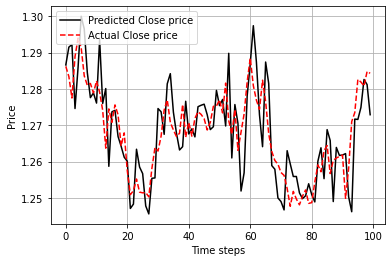

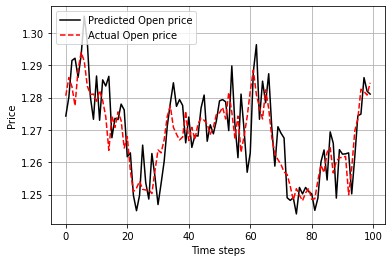

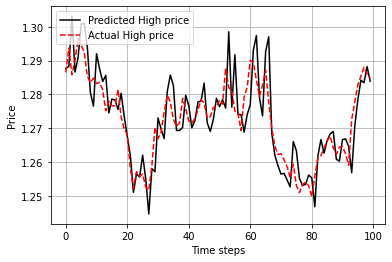

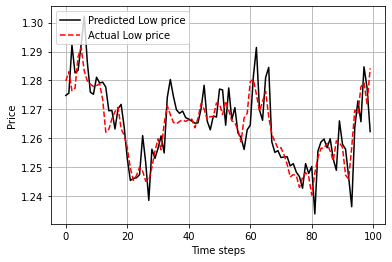

In [7]:

for idx in reversed(range(time_period)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == time_period - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == max_iter:
        print('Increase number of iterations')
        sys.exit(1)


    iters = 1
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))


mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(K),:]))

if PLOT_TYPE:
    hdl_p = plt.plot(range(K), predicted_stock_data)
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(K),np.flipud(dataset[range(K),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(K), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(K),np.flipud(dataset[range(K),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        # plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

# Create a portfolio using predicted stocks

In [8]:
def test_portfolio_strategy(actual, predicted):
    actual_df = pd.DataFrame(np.flipud(actual[range(K),:])).rename(columns={i:labels[i] for i in range(len(labels))})
    predicted_df = pd.DataFrame(np.flipud(predicted)).rename(columns={i:labels[i] for i in range(len(labels))})

    df = pd.DataFrame({"actual" : actual_df['Close'], "predicted" : predicted_df['Close']})

    df['actual_pct_chg'] = df['actual'].pct_change()
    df['predicted_pct_chg'] = df['predicted'].pct_change()

    print((df['actual_pct_chg'] + 1).cumprod())
    print((df.loc[df['predicted_pct_chg'] > 0, "predicted_pct_chg"] + 1).cumprod())

In [9]:
test_portfolio_strategy(dataset, predicted_stock_data)

0          NaN
1     0.997823
2     0.993236
3     1.002099
4     1.006064
        ...   
95    0.997201
96    0.996657
97    0.995802
98    0.998912
99    0.998523
Name: actual_pct_chg, Length: 100, dtype: float64
1     1.006521
2     1.007620
5     1.007700
7     1.011015
8     1.020638
11    1.022417
13    1.036169
14    1.038625
16    1.045658
19    1.047333
20    1.049844
23    1.051188
24    1.054968
26    1.057908
27    1.060933
29    1.062890
30    1.063741
31    1.070464
32    1.071315
33    1.090547
34    1.095568
36    1.103195
37    1.115762
38    1.124428
43    1.141134
44    1.145805
46    1.171974
48    1.178712
50    1.182593
53    1.186415
54    1.189118
58    1.191183
60    1.199640
63    1.204009
64    1.209517
65    1.219583
68    1.225549
69    1.226415
73    1.228581
74    1.237344
75    1.239116
76    1.243941
79    1.256908
80    1.258005
81    1.260998
82    1.263691
83    1.270872
86    1.292479
88    1.310307
90    1.313182
92    1.320274
93    1.332608
94   

In [10]:
# d = pd.DataFrame(np.flipud(dataset[range(K),:])).rename(columns={i:labels[i] for i in range(len(labels))})
# p = pd.DataFrame(np.flipud(predicted_stock_data)).rename(columns={i:labels[i] for i in range(len(labels))})

# df = pd.DataFrame({"actual" : d['Close'], "predicted" : p['Close']})

# df['actual_pct_chg'] = df['actual'].pct_change()
# df['predicted_pct_chg'] = df['predicted'].pct_change()

# print((df['actual_pct_chg'] + 1).cumprod())
# print((df.loc[df['predicted_pct_chg'] > 0, "predicted_pct_chg"] + 1).cumprod())


# Run for the currencies USD-JPY

In [11]:
dataset =  pd.read_excel('ExchangeRates.xlsx', sheet_name='usd-jpy')[labels]
dataset = np.array(dataset)

Optimum number of states are 14


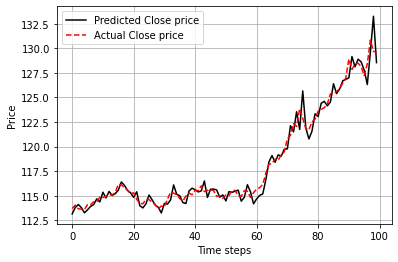

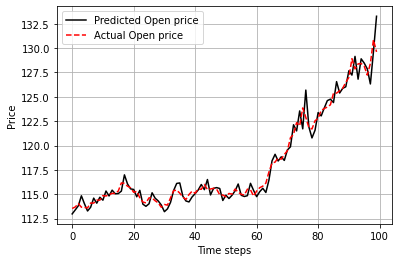

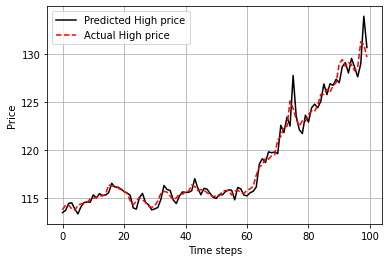

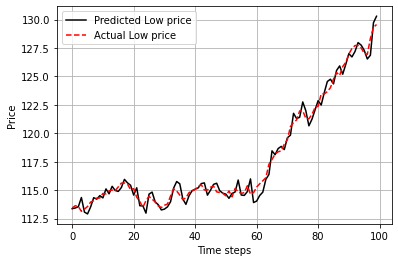

In [12]:
likelihoods = np.empty(13)
aics = np.empty(13)
bics = np.empty(13)

for num_states in range(2,15):
        num_params = num_states**2 + num_states
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=0.0001, n_iter=max_iter)
        model.fit(dataset[time_period:,:])
        if model.monitor_.iter == time_period:
            print('Increase number of iterations')
            sys.exit(1)
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])
    
opt_states = np.argmin(bics) + 2
print('Optimum number of states are {}'.format(opt_states))

predicted_stock_data = np.empty([0,dataset.shape[1]])


for idx in reversed(range(time_period)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == time_period - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == max_iter:
        print('Increase number of iterations')
        sys.exit(1)


    iters = 1
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))


mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(K),:]))

if PLOT_TYPE:
    hdl_p = plt.plot(range(K), predicted_stock_data)
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(K),np.flipud(dataset[range(K),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(K), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(K),np.flipud(dataset[range(K),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        # plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

In [13]:
test_portfolio_strategy(dataset, predicted_stock_data)

0          NaN
1     1.002990
2     0.999736
3     0.999384
4     0.999208
        ...   
95    1.118997
96    1.129551
97    1.150836
98    1.140721
99    1.139842
Name: actual_pct_chg, Length: 100, dtype: float64
1     1.036717
4     1.048700
5     1.055593
6     1.057891
8     1.066561
14    1.075152
17    1.079136
20    1.081591
23    1.091621
24    1.125382
26    1.142020
28    1.147941
32    1.149195
34    1.155795
41    1.168144
42    1.175432
45    1.186935
48    1.187655
50    1.193984
52    1.201677
53    1.202613
56    1.220103
59    1.222429
60    1.224121
63    1.225193
64    1.232588
65    1.234196
66    1.244378
69    1.245141
71    1.251518
72    1.253937
73    1.259874
74    1.265151
77    1.267598
78    1.283390
80    1.288419
81    1.291325
82    1.297024
83    1.300824
87    1.305461
89    1.312172
91    1.315728
96    1.321885
97    1.325603
Name: predicted_pct_chg, dtype: float64


# Run for the currencies USD-SGD

In [14]:
dataset =  pd.read_excel('ExchangeRates.xlsx', sheet_name='usd-sgd')[labels]
dataset = np.array(dataset)

Optimum number of states are 14


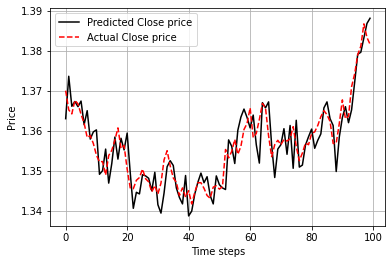

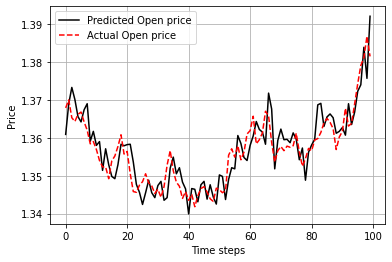

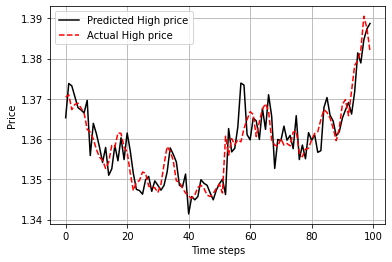

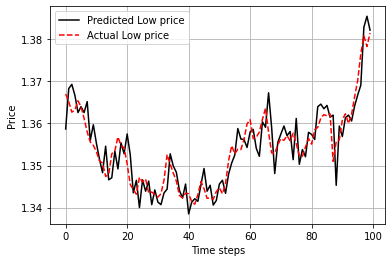

In [15]:
likelihoods = np.empty(13)
aics = np.empty(13)
bics = np.empty(13)

for num_states in range(2,15):
        num_params = num_states**2 + num_states
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=0.0001, n_iter=max_iter)
        model.fit(dataset[time_period:,:])
        if model.monitor_.iter == time_period:
            print('Increase number of iterations')
            sys.exit(1)
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])
    
opt_states = np.argmin(bics) + 2
print('Optimum number of states are {}'.format(opt_states))

predicted_stock_data = np.empty([0,dataset.shape[1]])


for idx in reversed(range(time_period)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == time_period - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == max_iter:
        print('Increase number of iterations')
        sys.exit(1)


    iters = 1
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))


mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(K),:]))

if PLOT_TYPE:
    hdl_p = plt.plot(range(K), predicted_stock_data)
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(K),np.flipud(dataset[range(K),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(K), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(K),np.flipud(dataset[range(K),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        # plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

In [16]:
test_portfolio_strategy(dataset, predicted_stock_data)

0          NaN
1     0.996497
2     0.995767
3     0.998248
4     0.997591
        ...   
95    1.006569
96    1.008102
97    1.012189
98    1.009707
99    1.008467
Name: actual_pct_chg, Length: 100, dtype: float64
8     1.002937
12    1.011481
13    1.012744
14    1.015864
19    1.019461
24    1.028290
26    1.036436
28    1.041334
32    1.047589
33    1.055930
35    1.056935
37    1.060531
38    1.066316
40    1.068354
41    1.069999
45    1.073402
46    1.074669
48    1.074988
49    1.075627
50    1.077385
52    1.079071
53    1.082845
55    1.084774
60    1.092957
62    1.094261
63    1.096216
64    1.100777
65    1.101755
69    1.103482
70    1.110144
72    1.112703
73    1.113198
74    1.113445
76    1.113777
78    1.121170
79    1.129395
81    1.131811
83    1.136412
86    1.143583
89    1.152992
92    1.159020
94    1.164042
96    1.165150
98    1.171546
Name: predicted_pct_chg, dtype: float64


# Run for the currencies USD-GBP

In [17]:
dataset =  pd.read_excel('ExchangeRates.xlsx', sheet_name='usd-gbp')[labels]
dataset = np.array(dataset)

Optimum number of states are 14


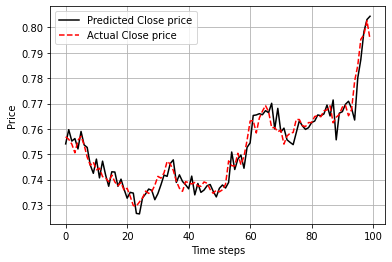

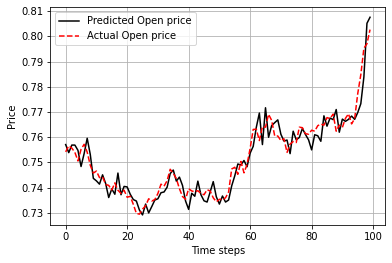

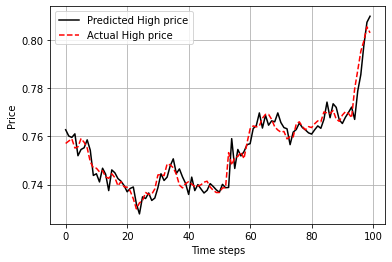

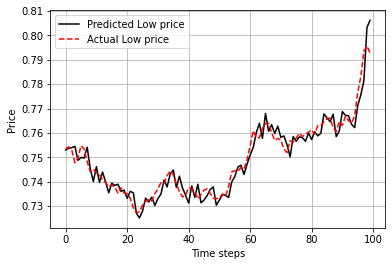

In [18]:
likelihoods = np.empty(13)
aics = np.empty(13)
bics = np.empty(13)

for num_states in range(2,15):
        num_params = num_states**2 + num_states
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=0.0001, n_iter=max_iter)
        model.fit(dataset[time_period:,:])
        if model.monitor_.iter == time_period:
            print('Increase number of iterations')
            sys.exit(1)
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])
    
opt_states = np.argmin(bics) + 2
print('Optimum number of states are {}'.format(opt_states))

predicted_stock_data = np.empty([0,dataset.shape[1]])


for idx in reversed(range(time_period)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == time_period - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == max_iter:
        print('Increase number of iterations')
        sys.exit(1)


    iters = 1
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))


mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(K),:]))

if PLOT_TYPE:
    hdl_p = plt.plot(range(K), predicted_stock_data)
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(K),np.flipud(dataset[range(K),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(K), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(K),np.flipud(dataset[range(K),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        # plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

In [19]:
test_portfolio_strategy(dataset, predicted_stock_data)

0          NaN
1     0.998679
2     0.996169
3     0.991677
4     0.998150
        ...   
95    1.036993
96    1.050733
97    1.053111
98    1.060378
99    1.050733
Name: actual_pct_chg, Length: 100, dtype: float64
6     1.006025
7     1.009692
12    1.030669
14    1.036462
17    1.036868
22    1.038778
23    1.041508
26    1.042751
27    1.044133
28    1.050489
30    1.063364
32    1.077495
34    1.078620
36    1.079183
42    1.086721
45    1.096800
48    1.098586
51    1.101882
52    1.105928
56    1.111194
58    1.122397
60    1.124836
61    1.126817
62    1.130780
64    1.144400
67    1.145172
71    1.150960
72    1.151742
76    1.152059
77    1.164742
78    1.165217
80    1.170783
81    1.177144
83    1.186084
84    1.186244
86    1.193322
87    1.202170
89    1.214180
91    1.219576
92    1.230860
93    1.232495
94    1.241162
96    1.247928
98    1.255364
Name: predicted_pct_chg, dtype: float64
